<a href="https://colab.research.google.com/github/shreyanshchordia/Faces/blob/master/Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siamese Neural Network

Siamese neural network is a class of neural network architectures that contain two or more identical sub networks. identical here means they have the same configuration with the same parameters and weights. Parameter updating is mirrored across both sub networks.It is used find the similarity of the inputs by comparing its feature vectors.

For more details check this blog : https://innovationincubator.com/siamaese-neural-network-with-paytorch-code-example/

## Steps to create classifier using Siamese Neural Network 


1.   **Data Preprocessing**
2.   **Define the Siamese Network**
3.   **Feature Vector Extraction**
4.   **Similarity Score Calculation**
5.   **Defininf Loss Function**
6.   **Optimizer**
7.   **Testing using One-Shot Learnig**
8.   **Making Predictions**



Let's  go step wise 

In [0]:
# Import all the necessary Library 
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import torch 
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd 


##Load Dataset

In [0]:
from sklearn.datasets import fetch_lfw_pairs
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_lfw_people
import keras

Using TensorFlow backend.


In [0]:
lfw_people = fetch_lfw_people(min_faces_per_person=10)

In [0]:
print(lfw_people.data.shape,lfw_people.images.shape,lfw_people.target.shape,lfw_people.target_names.shape)

(4324, 2914) (4324, 62, 47) (4324,) (158,)


In [0]:
data = [None]*lfw_people.target.shape[0]
for i in range(len(data)):
  data[i]=[]
  data[i].append(lfw_people.target[i,])
  data[i].append(lfw_people.target_names[data[i][0],])
  data[i].append(lfw_people.data[i,:])

In [0]:
image_dict = {}
for i in lfw_people.target_names:
  image_dict[i]=[]

for i in data:
  image_dict[i[1]].append(i[2])

In [0]:
sum=0
for i in image_dict.values():
  sum+=len(i)
print(sum)

4324


In [0]:
import random

In [0]:
dataset = [None]*(len(data)*1)
index = 0
# each sample of the dataset must have an achor,positive and negative
# I have 4324 images. If using each image I generate 1 sample, then I get a training data of size 4324
# I have data and image_dict
# data has all the images along with their label
# image_dict has seperated images using label names
for i in data:
    dataset[index]=[]
    dataset[index].append(i[2]) # 0
    temp = random.randrange(len(image_dict[i[1]])) 
    dataset[index].append(image_dict[i[1]][temp]) # 1
    temp = random.randrange(len(data))
    if(data[temp][0]==i[0]) : temp = (temp+1)%len(data)
    dataset[index].append(data[temp][2]) # 2
    dataset[index].append([i[1],i[1],data[temp][1]]) # label
    index+=1

In [0]:
print(len(dataset))
print(dataset[0],dataset[10],dataset[1000],sep="\n")

4324
[array([95.333336, 80.666664, 95.      , ..., 35.      , 39.      ,
       40.      ], dtype=float32), array([95.333336, 80.666664, 95.      , ..., 35.      , 39.      ,
       40.      ], dtype=float32), array([ 94.666664,  93.666664, 100.      , ...,  63.666668,  58.      ,
        55.333332], dtype=float32), ['Jacques Chirac', 'Jacques Chirac', 'Hillary Clinton']]
[array([ 10.       ,   7.3333335,   5.       , ..., 159.33333  ,
       161.33333  , 158.33333  ], dtype=float32), array([100.333336,  90.666664,  66.666664, ...,  84.      ,  75.      ,
        58.333332], dtype=float32), array([ 47.      ,  59.666668,  74.      , ..., 225.33333 , 224.66667 ,
       223.66667 ], dtype=float32), ['Gloria Macapagal Arroyo', 'Gloria Macapagal Arroyo', 'Jean-David Levitte']]
[array([ 10.666667,  11.333333,  45.      , ..., 183.33333 , 185.      ,
       189.66667 ], dtype=float32), array([145.      , 141.33333 , 144.      , ..., 143.66667 ,  52.      ,
        12.333333], dtype=float32),

Our dataset is ready with 4324 samples to train our siamese model over

In [0]:
dataset = np.array(dataset)
dataset = dataset[:,0:3]
print(dataset.shape)

(4324, 3)


### Preprocessing and Loading Dataset

We preprocessed all the images and loaded them as .npy files which is easy to transfer . You can follow your own preprocessing steps .


In [0]:
class SiameseNetworkDataset():
    
    def __init__(self,data=None,transform=None):
        # used to prepare the labels and images path
        self.data = data 
        self.transform = transform

    def __getitem__(self,index):
        
        img0 = torch.tensor(self.data[index][0].reshape(62,47))
        img1 = torch.tensor(self.data[index][1].reshape(62,47))
        img2 = torch.tensor(self.data[index][2].reshape(62,47))
        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img0,img1,img2
    
    def __len__(self):
        return len(self.data)

In [0]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseNetworkDataset(dataset)

In [0]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
print(example_batch[0].size())
print(example_batch[1].size())
print(example_batch[2].size())

## Siamese Network Definition

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

        )
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(3840, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2))
        
  
  
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2,input3):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        # forward pass of input 3
        output3 = self.forward_once(input3)
        return output1, output2, output3


### Loss Function

In [0]:
class TripleLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(TripleLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor , positive , negative):
        d_ap = F.pairwise_distance(anchor, positive)
        d_an = F.pairwise_distance(anchor, negative)
        x = (d_ap - d_an + self.margin).float().mean()
        if x>0:
          triple_loss = x
        else: triple_loss = x - x

        return triple_loss

### Train the Model

In [0]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=256)

In [0]:
# Check whether you have GPU is loaded or not
if torch.cuda.is_available():
    print('Yes')

Yes


In [0]:
# Declare Siamese Network
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = TripleLoss()
# Declare Optimizer
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

In [0]:
def train():
    counter = []
    loss_history = [] 
    iteration_number= 0
    
    for epoch in range(0,epochs):
        temp=[]
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , img2 = data
            img0, img1 , img2 = img0.cuda(), img1.cuda() , img2.cuda()
            optimizer.zero_grad()
            img0 = img0.reshape(-1,1,62,47)
            img1 = img1.reshape(-1,1,62,47)
            img2 = img2.reshape(-1,1,62,47)
            output1,output2,output3 = net(img0,img1,img2)
            loss = criterion(output1,output2,output3)
            loss.backward()
            optimizer.step()
            temp.append(loss.item())
        loss_history.append(np.asarray(temp).mean())
        print(loss_history[-1])
    
    plt.plot(loss_history)
    plt.show()
    return net

4.257913796340718
2.1230578001807716
2.699061393737793
1.7247612897087545
1.5363181969698738
0.67587490642772
0.18471094440011418
0.20510726816513958
0.4904266806209789
0.9190531969070435


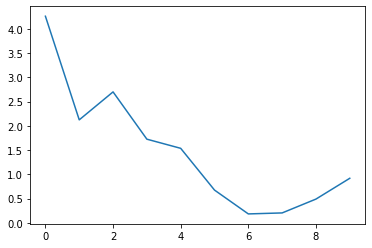

Model Saved Successfully


In [0]:
epochs= 10
batchsize=256
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train the model
model = train()
torch.save(model.state_dict(), "/content/model.pt")
print("Model Saved Successfully")

In [0]:
torch.cuda.empty_cache()

In [0]:
# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork()
model.load_state_dict(torch.load("/content/model.pt"))

<All keys matched successfully>

### Accuracy Check

In [0]:
def cal_dist(a1,a2):
  return F.pairwise_distance(a1,a2)

In [0]:
sim_arr=[]
dissim_arr=[]
for i in dataset[0:100,:]:
  with torch.no_grad():
    img0 = torch.tensor(i[0].reshape(-1,1,62,47))
    img1 = torch.tensor(i[1].reshape(-1,1,62,47))
    img2 = torch.tensor(i[2].reshape(-1,1,62,47))
    a,p,n = model(img0,img1,img2)
    sim_arr.append(cal_dist(a,p))
    dissim_arr.append(cal_dist(a,n))
s = np.asarray(sim_arr).mean()
d = np.asarray(dissim_arr).mean()
print("Mean distance between the embeddings of Similar images is",s)
print("Mean distance between the embeddings of Dissimilar images is",d)

Mean distance between the embeddings of Similar images is 77.63261
Mean distance between the embeddings of Dissimilar images is 96.963


So even on just 5 epochs, my model is taking a large amount of time.

My focus is not on building a perfectly trained Siamese Network for one shot learning, rather my focus is on understanding that how exactly a siamese network is able to do this.

The triple loss focuses on increasing the distance between the embeddings of dissimliar image in every step. If we have enough time and computation power then training this model with even better samples and for larger number of epochs  we can build a very strong siamese network that can produce perfect embeddings for face recognition.  